In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd /content/drive/MyDrive/STECH/time-series

/content/drive/MyDrive/STECH/time-series


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [84]:
df = pd.read_csv('FX_USDCHF, 240 (2).csv')

In [85]:
df.head()

,time,open,high,low,close
0,2015-04-23T20:00:00+07:00,0.96364,0.96545,0.95375,0.95405
1,2015-04-24T00:00:00+07:00,0.95405,0.95504,0.95300,0.95425
2,2015-04-24T04:00:00+07:00,0.95425,0.95613,0.95365,0.95424
3,2015-04-24T08:00:00+07:00,0.95424,0.95729,0.95424,0.95631
4,2015-04-24T12:00:00+07:00,0.95631,0.95741,0.95100,0.95256


In [86]:
cols = ['time','close']
df = df[cols]

In [87]:
df = df.astype({'time':'datetime64'})

In [88]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
df['date'] = pd.to_datetime(df['date'])
df.drop('time',axis=1,inplace=True)

In [89]:
df.Timestamp = pd.to_datetime(df.date, format='%Y-%m-%d')
df.index = df.Timestamp
df = df.resample('D').mean()
df = df.asfreq(pd.infer_freq(df.index))

In [90]:
df = df.interpolate(method='time')

In [91]:
df.isnull().sum()

close    0
dtype: int64

In [92]:
df.head()

,close
date,
2015-04-23,0.954180
2015-04-24,0.954372
2015-04-25,0.954076
2015-04-26,0.953780
2015-04-27,0.954815


In [93]:
from pmdarima.arima import auto_arima

In [94]:
test_size = 0.2
train_samples = int((1-test_size)*len(df))

In [95]:
train_data = df[:train_samples]
test_data = df[train_samples:]

In [96]:
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2020-12-30 00:00:00', freq='D'),
 Timestamp('2022-06-02 00:00:00', freq='D'))

In [97]:
auto_model = auto_arima(train_data['close'], start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      m=12,             
                      d=1,          
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=14.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-16824.816, Time=0.52 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-17695.405, Time=2.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-18171.413, Time=3.55 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-17130.166, Time=1.43 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-18133.349, Time=7.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-18305.289, Time=11.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-18285.630, Time=10.39 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-18038.630, Time=7.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-18336.061, Time=9.84 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-18202.166, Time=8.19 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-18315.883, Time=11.63 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-18334.986, Time=7.69 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=-18336.334, Time=17.

In [98]:
auto_model

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [99]:
auto_model.fit(train_data['close'])

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [121]:
future_forecast = auto_model.predict(n_periods=len(test_data))

In [113]:
len(future_forecast), len(test_data)

(520, 520)

In [114]:
test_data.index

DatetimeIndex(['2020-12-30', '2020-12-31', '2021-01-01', '2021-01-02',
               '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08',
               ...
               '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27',
               '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31',
               '2022-06-01', '2022-06-02'],
              dtype='datetime64[ns]', name='date', length=520, freq='D')

In [115]:
dt = pd.date_range('30-12-2020','02-06-2022')
idx = pd.DatetimeIndex(dt)

In [ ]:
future_forecast = pd.Series(future_forecast,index=test_data.index)

In [127]:
future_forecast = pd.DataFrame(future_forecast, columns=['close'])
future_forecast

,close
date,
2020-12-30,0.883078
2020-12-31,0.882528
2021-01-01,0.881938
2021-01-02,0.881633
2021-01-03,0.880985
...,...
2022-05-29,0.709158
2022-05-30,0.709068
2022-05-31,0.708670


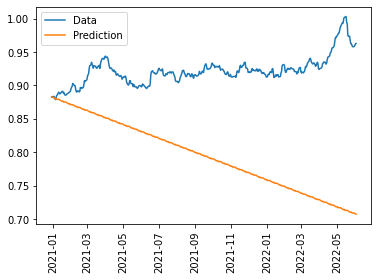

In [126]:
plt.plot(test_data['close'])
plt.plot(future_forecast['close'])
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))

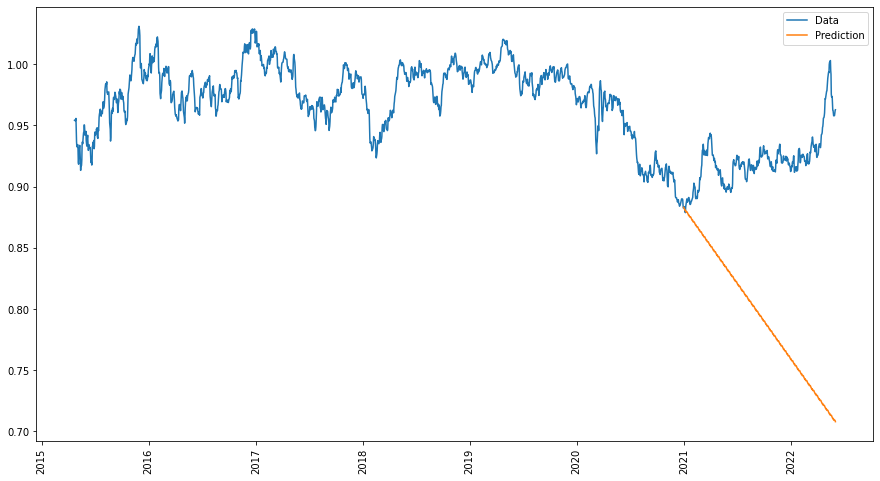

In [128]:
plt.figure(figsize=(15,8))
plt.plot(df['close'])
plt.plot(future_forecast.shift(1))
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))
plt.show()

In [129]:
residuals_1 = test_data['close'] - future_forecast['close']
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_1/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_1**2)))

Mean Absolute Percent Error:  0.136
Root Mean Squared Error:  0.14316639803280362


**Rolling Forcast of AutoArima**

In [131]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df[:end_date - timedelta(days=1)]
  model_ARIMA = ARIMA(train_data['close'], order=(3,1,1))
  model_ARIMA_fit = model_ARIMA.fit()
  pred_ARIMA = model_ARIMA_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred_ARIMA.loc[end_date]

In [132]:
predictions_rolling = pd.DataFrame(data=predictions_rolling,index=test_data.index, columns=['close'])
predictions_rolling

,close
date,
2020-12-30,-0.001567
2020-12-31,-0.000649
2021-01-01,0.000248
2021-01-02,0.000050
2021-01-03,0.000075
...,...
2022-05-29,-0.000099
2022-05-30,0.000241
2022-05-31,-0.000139


In [133]:
residuals_rolling = test_data['close'] - predictions_rolling['close']
residuals_rolling

date
2020-12-30    0.884037
2020-12-31    0.883389
2021-01-01    0.882768
2021-01-02    0.883243
2021-01-03    0.883495
                ...   
2022-05-29    0.957969
2022-05-30    0.957844
2022-05-31    0.960099
2022-06-01    0.961064
2022-06-02    0.962334
Freq: D, Name: close, Length: 520, dtype: float64

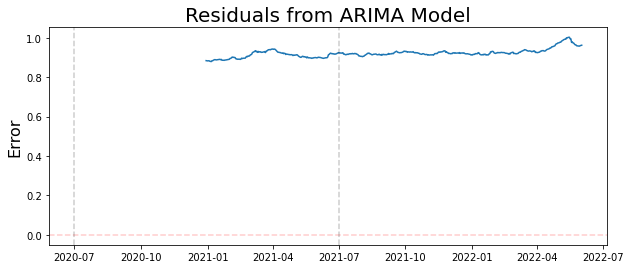

In [135]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2020,2022):
    plt.axvline(pd.to_datetime(str(year)+'-07-01'), color='k', linestyle='--',alpha=0.2)

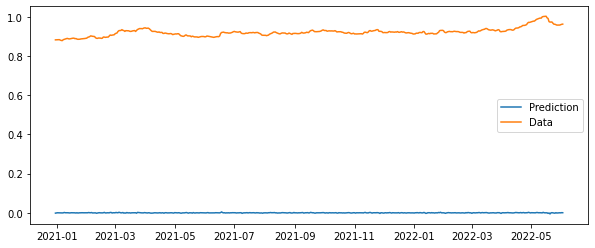

In [136]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling['close'])
plt.plot(test_data['close'])
plt.legend(('Prediction','Data'))

In [137]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_rolling/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_1**2)))

Mean Absolute Percent Error:  1.0
Root Mean Squared Error:  0.14316639803280362


ARMA

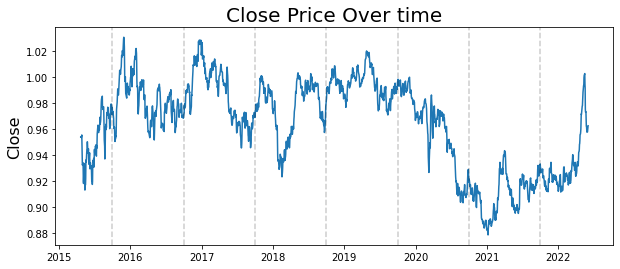

In [138]:
plt.figure(figsize=(10,4))
plt.plot(df.close)
plt.title('Close Price Over time', fontsize=20)
plt.ylabel('Close',fontsize=16)
for year in range(2015, 2022):
  plt.axvline(pd.to_datetime(str(year)+ '-10-01'),color='k', linestyle='--', alpha=0.2)

In [139]:
def adf_test(series):
  result = adfuller(series)
  print('ADF Statistics: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [140]:
adf_test(df.close)

ADF Statistics: -2.5721338087796926
p-value: 0.09889449122815369
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [141]:
adf_test(df.close.diff().dropna())

ADF Statistics: -15.816756435186793
p-value: 1.0313614422336799e-28
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


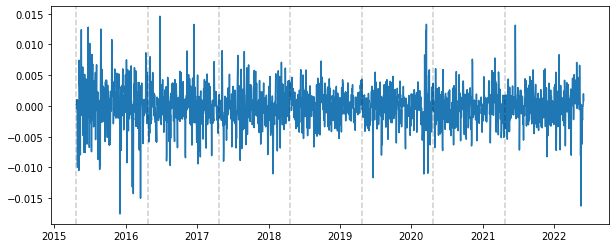

In [143]:
plt.figure(figsize=(10,4))
plt.plot(df.close.diff().dropna())
for year in range(2015,2022):
  plt.axvline(pd.to_datetime(str(year)+'-04-23'), color='k',linestyle='--',alpha=0.2)

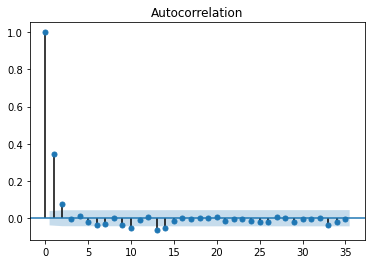

In [144]:
acf_plot = plot_acf(df.close.diff().dropna())
#MA

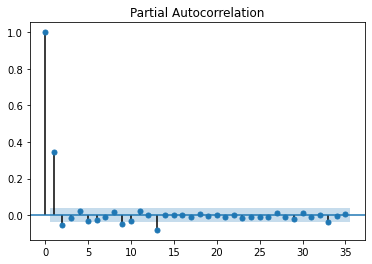

In [145]:
pacf_plot = plot_pacf(df.close.diff().dropna())
#AR

In [147]:
from statsmodels.tsa.arima_model import ARMA
def evaluate_arima_model(X, ar_order):
	# prepare training dataset
  train_size = int(len(X)*0.7)
  train, test = X[0:train_size], X[train_size:]
  model_ARMA = ARMA(train_data, order=ar_order)
  model_ARMA_fit = model_ARMA.fit()
  pred_start_date = test.index[0]
  pred_end_date = test.index[-1]
  predict_ARMA = model_ARMA_fit.predict(start=pred_start_date, end=pred_end_date)
  rmse = np.sqrt(mean_squared_error(test, predict_ARMA))
  return rmse

In [148]:
def evaluate_models(dataset, p_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for q in q_values:
      order = (p,q)
      try:
        rmse = evaluate_arima_model(dataset, order)
        if rmse < best_score:
          best_score, best_cfg = rmse, order
        print('ARMA%s RMSE=%.3f' % (order,rmse))
      except:
        continue
  print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))

In [149]:
p_values = [1,2]
q_values = [1,2]
evaluate_models(df.close, p_values, q_values)

ARMA(1, 1) RMSE=0.002
ARMA(1, 2) RMSE=0.002
ARMA(2, 1) RMSE=0.002
ARMA(2, 2) RMSE=0.002
Best ARMA(2, 2) RMSE=0.002


In [150]:
model_arma = ARMA(train_data['close'], order=(2,2))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2597
Model:                     ARMA(2, 2)   Log Likelihood               11715.572
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 02 Jun 2022   AIC                         -23419.143
Time:                        03:20:12   BIC                         -23383.971
Sample:                    04-23-2015   HQIC                        -23406.399
                         - 06-01-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9636      0.011     88.458      0.000       0.942       0.985
ar.L1.close     0.8069      0.213      3.790      0.000       0.390       1.224
ar.L2.close     0.1854      0.212      0.875      0.381      -0.230       0.600
ma.L1.close     0.5546      0.211      2.631      0.009       0.141       0.968
ma.L2.close     0.1580      0.070      2.258      0.024       0.021       0.295
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0066           +0.0000j            1.0066            0.0000
AR.2           -5.3592           +0.0000j            5.3592            0.5000
MA.1           -1.7551           -1.8026j            2.5158           -0.3729
MA.2           -1.7551           +1.8026j            2.5158            0.3729
-----------------------------------------------------------------------------
"""

In [151]:
predictions_arma = model_fit_arma.predict(start=pred_start_date, end=pred_end_date)

In [152]:
residuals_2 = test_data['close'] - predictions_arma
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_2/test_data['close'])),4))
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_2**2)))

Mean Absolute Percent Error:  0.0018
Root Mean Squared Error:  0.002376231620789827


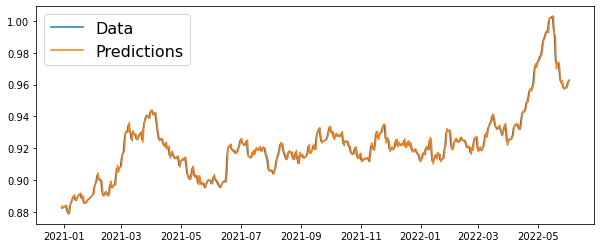

In [153]:
plt.figure(figsize=(10,4))
plt.plot(test_data['close'])
plt.plot(predictions_arma)
plt.legend(('Data','Predictions'), fontsize=16)

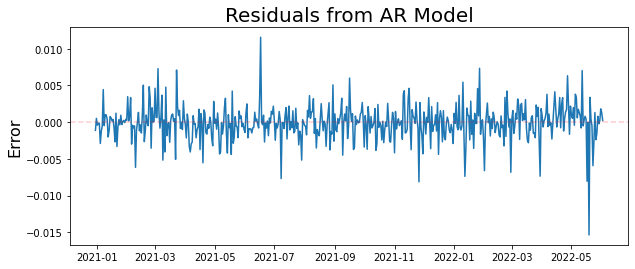

In [154]:
plt.figure(figsize=(10,4))
plt.plot(residuals_2)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

**FORECAST THE NEXT 12 MONTHS**

In [164]:
test_data_next = pd.date_range('2022-06-03','2023-05-03', freq='D').strftime('%Y-%m-%d').tolist()

In [165]:
new_predict = pd.DataFrame({'DATE':test_data_next})
new_predict['DATE'] = pd.to_datetime(new_predict['DATE'])
new_predict['new_predict'] = 0
new_predict.Timestamp = pd.to_datetime(new_predict.DATE, format = '%Y-%m-%d')
new_predict.index = new_predict.Timestamp
new_predict = new_predict.asfreq(pd.infer_freq(new_predict.index))
new_predict.drop('DATE',axis=1,inplace=True)

In [166]:
future_forecast = model_fit_arma.predict(start=test_data.index[0], end=new_predict.index[-1])
future_forecast

2020-12-30    0.883583
2020-12-31    0.882225
2021-01-01    0.883426
2021-01-02    0.883444
2021-01-03    0.883716
                ...   
2023-04-29    0.963486
2023-04-30    0.963487
2023-05-01    0.963487
2023-05-02    0.963488
2023-05-03    0.963489
Freq: D, Length: 855, dtype: float64

In [167]:
new_predict['new_predict'] = future_forecast[test_data.index[-1]:]

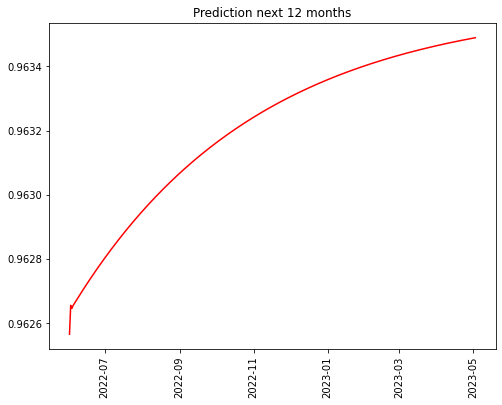

In [168]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.show()

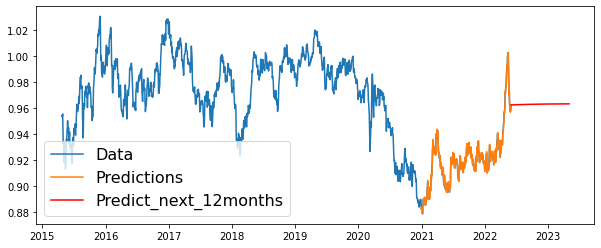

In [169]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(predictions_arma)
plt.plot(future_forecast[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)

**Rolling Forecast**

In [163]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df[:end_date - timedelta(days=1)]
  model_roll = ARMA(train_data, order=(2,2))
  model_roll_fit = model_roll.fit()
  pred_roll = model_roll_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred_roll.loc[end_date]

In [170]:
residuals_rolling = test_data['close'] - predictions_rolling

In [174]:
test_data

,close
date,
2020-12-30,0.882470
2020-12-31,0.882740
2021-01-01,0.883017
2021-01-02,0.883293
2021-01-03,0.883570
...,...
2022-05-29,0.957870
2022-05-30,0.958085
2022-05-31,0.959960


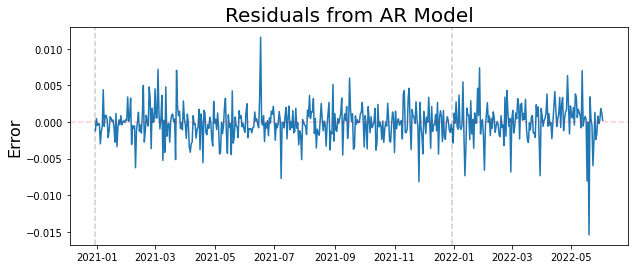

In [175]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2020,2022):
    plt.axvline(pd.to_datetime(str(year)+'-12-30'), color='k', linestyle='--',alpha=0.2)

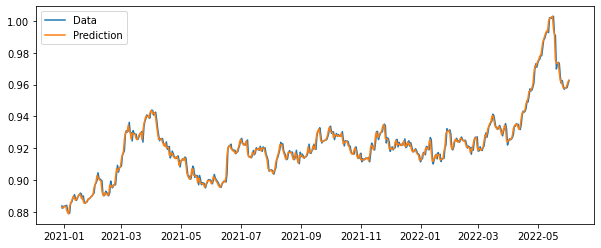

In [176]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling)
plt.plot(test_data['close'])
plt.legend(('Data','Prediction'))

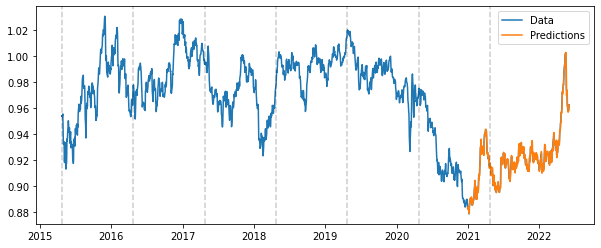

In [178]:
plt.figure(figsize=(10,4))
plt.plot(df['close'])
plt.plot(predictions_rolling)
plt.legend(('Data','Predictions'))
for year in range(2015,2022):
    plt.axvline(pd.to_datetime(str(year) + '-04-23'), color='k', linestyle='--',alpha=0.2)

In [180]:
new_predict_rolling = new_predict.copy()

In [183]:
new_predict_rolling.index[0], new_predict_rolling.index[-1]

(Timestamp('2022-06-03 00:00:00', freq='D'),
 Timestamp('2023-05-03 00:00:00', freq='D'))

In [185]:
future_forecast_roll = model_roll_fit.predict(start=test_data.index[0], end=new_predict_rolling.index[-1])
future_forecast_roll

2020-12-30    0.883583
2020-12-31    0.882225
2021-01-01    0.883426
2021-01-02    0.883444
2021-01-03    0.883716
                ...   
2023-04-29    0.963486
2023-04-30    0.963487
2023-05-01    0.963487
2023-05-02    0.963488
2023-05-03    0.963489
Freq: D, Length: 855, dtype: float64

In [211]:
future_1 = future_forecast_roll[len(test_data):]
future_1 = pd.DataFrame(future_1, columns=['close'])
future_1

,close
2022-06-03,0.962656
2022-06-04,0.962646
2022-06-05,0.962655
2022-06-06,0.962661
2022-06-07,0.962667
...,...
2023-04-29,0.963486
2023-04-30,0.963487
2023-05-01,0.963487
2023-05-02,0.963488


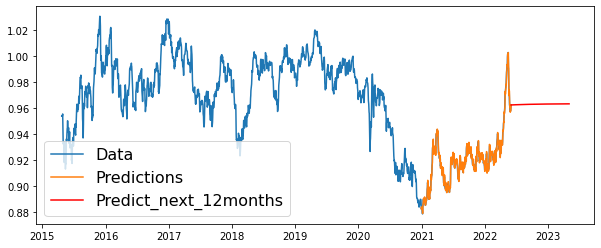

In [186]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(predictions_rolling)
plt.plot(future_forecast_roll[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)

**SARIMAX**

<BarContainer object of 20 artists>

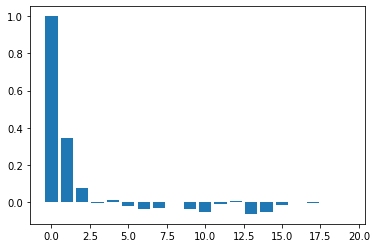

In [187]:
acf_vals = acf(df.close.diff().dropna())
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

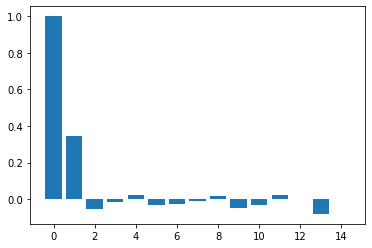

In [188]:
pacf_vals = pacf(df.close.diff().dropna())
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [201]:
train_data = df[:train_samples]
test_data = df[train_samples:]
train_data

,close
date,
2015-04-23,0.954180
2015-04-24,0.954372
2015-04-25,0.954076
2015-04-26,0.953780
2015-04-27,0.954815
...,...
2020-12-25,0.889887
2020-12-26,0.889863
2020-12-27,0.889840


In [202]:
model_SARIMAX = SARIMAX(train_data, order=(3,1,1),seasonal_order=(0,1,2,12))
model_SARIMAX_fit = model_SARIMAX.fit()
model_SARIMAX_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                 2078
Model:             SARIMAX(3, 1, 1)x(0, 1, 2, 12)   Log Likelihood                9191.466
Date:                            Thu, 02 Jun 2022   AIC                         -18368.933
Time:                                    03:49:56   BIC                         -18329.502
Sample:                                04-23-2015   HQIC                        -18354.478
                                     - 12-29-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2151      0.730      0.295      0.768      -1.217       1.647
ar.L2         -0.0349      0.285     -0.122      0.903      -0.594       0.524
ar.L3         -0.0482      0.082     -0.586      0.558      -0.210       0.113
ma.L1          0.1766      0.732      0.241      0.809      -1.257       1.610
ma.S.L12      -0.8950      0.021    -43.245      0.000      -0.936      -0.854
ma.S.L24       0.0109      0.020      0.550      0.582      -0.028       0.050
sigma2      7.882e-06   1.59e-07     49.569      0.000    7.57e-06    8.19e-06
===================================================================================
Ljung-Box (Q):                       53.18   Jarque-Bera (JB):               930.67
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [203]:
predictions_SARIMAX = model_SARIMAX_fit.forecast(len(test_data))
predictions_SARIMAX = pd.DataFrame(predictions_SARIMAX,columns=['close'])
predictions_SARIMAX

,close
2020-12-30,0.883078
2020-12-31,0.882528
2021-01-01,0.881938
2021-01-02,0.881633
2021-01-03,0.880985
...,...
2022-05-29,0.709158
2022-05-30,0.709068
2022-05-31,0.708670
2022-06-01,0.707865


In [204]:
residuals_SARIMAX = test_data['close'] - predictions_SARIMAX['close']
residuals_SARIMAX

date
2020-12-30   -0.000608
2020-12-31    0.000212
2021-01-01    0.001079
2021-01-02    0.001660
2021-01-03    0.002585
                ...   
2022-05-29    0.248712
2022-05-30    0.249017
2022-05-31    0.251290
2022-06-01    0.254068
2022-06-02    0.255343
Freq: D, Name: close, Length: 520, dtype: float64

Text(0, 0.5, 'Error')

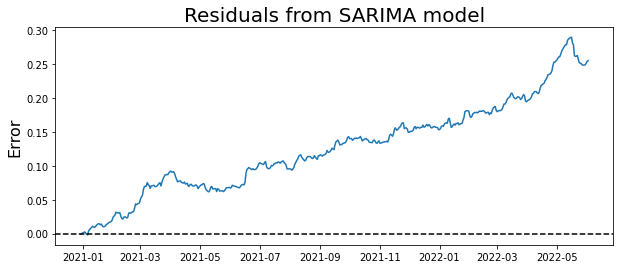

In [205]:
plt.figure(figsize=(10,4))
plt.plot(residuals_SARIMAX)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error',fontsize=16)

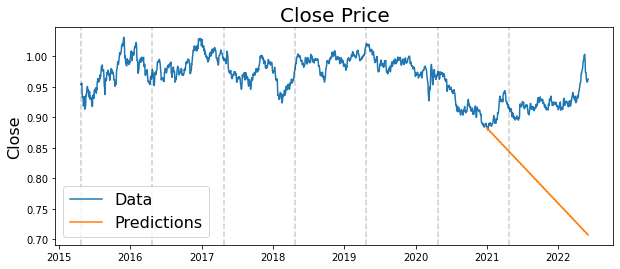

In [206]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions_SARIMAX)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Close Price', fontsize=20)
plt.ylabel('Close', fontsize=16)
for year in range(2015,2022):
    plt.axvline(pd.to_datetime(str(year)+'-04-23'), color='k', linestyle='--', alpha=0.2)

In [208]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_SARIMAX/test_data['close'])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Mean Absolute Percent Error: 0.136
Root Mean Squared Error: 0.14316639803280362


In [212]:
future_SARIMAX = model_SARIMAX_fit.predict(start=test_data.index[0], end=new_predict_rolling.index[-1])

In [214]:
future_2 = future_SARIMAX[len(test_data):]
future_2 = pd.DataFrame(future_2, columns = ['close'])

In [215]:
future_2

,close
2022-06-03,0.706794
2022-06-04,0.706248
2022-06-05,0.706254
2022-06-06,0.706445
2022-06-07,0.705309
...,...
2023-04-29,0.595731
2023-04-30,0.595724
2023-05-01,0.595634
2023-05-02,0.595236


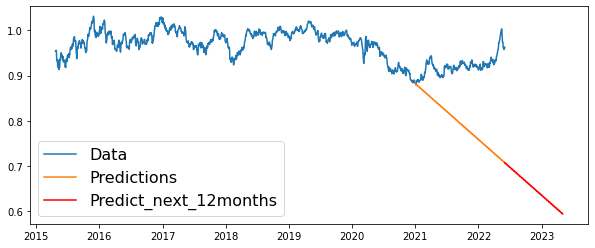

In [216]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(predictions_SARIMAX)
plt.plot(future_SARIMAX[test_data.index[-1]:], color='red')
plt.legend(('Data','Predictions','Predict_next_12months'), fontsize=16)